# Tax Credit Linear Analysis: 

Using Ordinary Least Squares models and demographic features to predict participation in the tax credit program

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
)

DEBUG:jupyter_black:config: {'line_length': 79}


In [3]:
# Import packages
import os
import warnings

# import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt

import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import median_test, shapiro
from sklearn import linear_model, preprocessing
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate

In [4]:
from src.linear_analysis import (
    quantile_regression_both_response_subplots_with_bootstrap_and_histograms_updated,
)

In [5]:
from statsmodels.stats.diagnostic import het_white


labels = [
    "Test Statistic",
    "Test Statistic p-value",
    "F-Statistic",
    "F-Test p-value",
]

In [6]:
warnings.filterwarnings("ignore")

In [7]:
# Prep demographic data
CSV_DIR = os.path.join("..", "csv_data")


demographics_colors = ["#1b9e77", "#7570b3", "#d95f02"]
pvi_colors = ["#e41a1c", "#984ea3", "#377eb8"]  # red, purple, blue

In [8]:
credits_race_income_demographics_df = pd.read_csv(
    os.path.join(
        CSV_DIR,
        "tax_credits_with_agi_demographic_zipcode_decade_updated_interpolated.csv",
    )
)

In [9]:
credits_race_income_demographics_df.describe()

,STATEFIPS,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone
count,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06,1.742205e+06
mean,2.964654e+01,4.853559e+04,3.269907e+00,9.654258e+02,1.989251e+01,1.695919e+01,2.151726e+02,2.014561e+03,2.563680e+02,2.213815e+00,2.137813e+00,8.634092e-01,2.855695e+01,5.938536e+04,7.584016e+01
std,1.511103e+01,2.724468e+04,1.626384e+00,1.630797e+03,4.465364e+01,5.989147e+01,4.218685e+02,3.442071e+00,6.630987e+02,5.088919e+00,1.697609e+00,1.909201e+00,3.006329e+01,2.474790e+04,2.388192e+01
min,1.000000e+00,1.001000e+03,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.009000e+03,0.000000e+00,0.000000e+00,2.777508e-03,0.000000e+00,0.000000e+00,6.278000e+03,7.352941e-02
25%,1.800000e+01,2.641500e+04,2.000000e+00,9.800000e+01,0.000000e+00,0.000000e+00,1.000000e-04,2.012000e+03,0.000000e+00,0.000000e+00,1.116608e+00,0.000000e+00,0.000000e+00,4.320400e+04,6.515207e+01
50%,2.900000e+01,4.843300e+04,3.000000e+00,3.100000e+02,0.000000e+00,0.000000e+00,5.500000e+01,2.015000e+03,0.000000e+00,0.000000e+00,1.616676e+00,0.000000e+00,1.810994e+01,5.394800e+04,8.546646e+01
75%,4.200000e+01,7.052900e+04,5.000000e+00,1.110000e+03,3.000000e+01,1.000000e+01,2.200000e+02,2.018000e+03,2.666667e+02,2.369668e+00,2.437284e+00,1.331801e+00,5.000000e+01,6.927500e+04,9.385532e+01
max,5.600000e+01,9.992900e+04,6.000000e+00,4.444000e+04,1.369000e+03,7.324000e+03,9.820000e+03,2.020000e+03,1.531429e+05,1.357143e+02,8.271593e+00,6.051008e+02,1.000000e+02,2.476040e+05,1.000000e+02


In [10]:
credits_race_income_demographics_df[
    credits_race_income_demographics_df["value_returns"] > 100000
]

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone
31789,4,AZ,86333,4,100.0,21.0,3216.0,58.0,2009,153142.857143,21.000000,3.438643,6.10706,58.000000,37744.0,88.065866
309130,20,KS,67013,3,235.0,39.0,5185.0,66.0,2009,132948.717949,16.595745,5.490970,3.02237,28.085106,45104.0,93.297924


In [11]:
credits_race_income_demographics_df[
    (credits_race_income_demographics_df["Total Returns"] < 1)
]

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone


In [12]:
credits_race_income_demographics_df[
    (credits_race_income_demographics_df["Number of real estate taxes"] < 1)
    & (credits_race_income_demographics_df["Total Returns"] > 1)
]

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone
82,1,AL,35006,1,518.0,0.0001,0.0001,0.0001,2010,0.0,0.0,5.490163,0.000000,0.0,44663.0,91.893624
92,1,AL,35006,1,500.0,20.0000,5.0000,0.0000,2012,250.0,4.0,1.538105,2.600602,0.0,44663.0,91.287222
97,1,AL,35006,1,440.0,0.0000,0.0000,0.0000,2013,0.0,0.0,2.235300,0.000000,0.0,44663.0,90.984021
107,1,AL,35006,1,430.0,0.0000,0.0000,0.0000,2015,0.0,0.0,1.764989,0.000000,0.0,44663.0,90.377619
221,1,AL,35014,1,670.0,0.0000,0.0000,0.0000,2014,0.0,0.0,1.868149,0.000000,0.0,37835.0,51.446183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742200,51,VA,22729,2,20.0,0.0000,0.0000,0.0000,2020,0.0,0.0,1.339147,0.000000,0.0,76667.0,51.174497
1742201,51,VA,22729,3,30.0,0.0000,0.0000,0.0000,2020,0.0,0.0,1.339147,0.000000,0.0,76667.0,51.174497
1742202,53,WA,98833,1,40.0,0.0000,0.0000,0.0000,2020,0.0,0.0,0.964554,0.000000,0.0,69615.0,89.166667
1742203,53,WA,98833,3,30.0,0.0000,0.0000,0.0000,2020,0.0,0.0,0.964554,0.000000,0.0,69615.0,89.166667


In [13]:
credits_race_income_demographics_df

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone
0,1,AL,35004,1,1468.0,0.0001,0.0001,112.0,2009,0.000000,0.000000,5.108432,0.000000,7.629428,62281.0,86.515269
1,1,AL,35004,2,1271.0,82.0000,45.0000,450.0,2009,548.780488,6.451613,5.108432,1.262934,35.405193,62281.0,86.515269
2,1,AL,35004,3,911.0,73.0000,58.0000,524.0,2009,794.520548,8.013172,5.108432,1.568617,57.519210,62281.0,86.515269
3,1,AL,35004,4,552.0,63.0000,36.0000,398.0,2009,571.428571,11.413043,5.108432,2.234158,72.101449,62281.0,86.515269
4,1,AL,35004,5,371.0,41.0000,31.0000,298.0,2009,756.097561,11.051213,5.108432,2.163328,80.323450,62281.0,86.515269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742200,51,VA,22729,2,20.0,0.0000,0.0000,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497
1742201,51,VA,22729,3,30.0,0.0000,0.0000,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497
1742202,53,WA,98833,1,40.0,0.0000,0.0000,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667
1742203,53,WA,98833,3,30.0,0.0000,0.0000,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667


## Filtering data

In [16]:
credits_race_filtered_df = credits_race_income_demographics_df[
    credits_race_income_demographics_df["percent_white_alone"].notna()
]

credits_race_filtered_df["value_returns"] = credits_race_filtered_df[
    "value_returns"
].fillna(0, inplace=False)

credits_race_filtered_df["percent_returns"] = credits_race_filtered_df[
    "percent_returns"
].fillna(0, inplace=False)

credits_race_filtered_df = credits_race_filtered_df[
    credits_race_filtered_df["percent_returns"] <= 100
]

credits_race_filtered_df = credits_race_filtered_df[
    credits_race_filtered_df["Total Returns"] >= 1
]

credits_race_filtered_df = credits_race_filtered_df[
    (credits_race_filtered_df["Number of returns"] > 1)
    | (credits_race_filtered_df["Number of returns"] == 0)
]

credits_race_filtered_df = credits_race_filtered_df[
    (credits_race_filtered_df["Amount of returns"] > 1)
    | (credits_race_filtered_df["Amount of returns"] == 0)
]

In [18]:
credits_race_participated_filtered_df = credits_race_filtered_df[
    credits_race_filtered_df["Number of returns"] > 0
]

In [19]:
credits_race_participated_filtered_df

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone
1,1,AL,35004,2,1271.0,82.0,45.0,450.0,2009,548.780488,6.451613,5.108432,1.262934,35.405193,62281.0,86.515269
2,1,AL,35004,3,911.0,73.0,58.0,524.0,2009,794.520548,8.013172,5.108432,1.568617,57.519210,62281.0,86.515269
3,1,AL,35004,4,552.0,63.0,36.0,398.0,2009,571.428571,11.413043,5.108432,2.234158,72.101449,62281.0,86.515269
4,1,AL,35004,5,371.0,41.0,31.0,298.0,2009,756.097561,11.051213,5.108432,2.163328,80.323450,62281.0,86.515269
7,1,AL,35004,2,1248.0,69.0,39.0,406.0,2010,565.217391,5.528846,5.490163,1.007046,32.532051,62281.0,85.806080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741300,56,WY,83001,5,820.0,60.0,98.0,480.0,2016,1633.333333,7.317073,1.428404,5.122553,58.536585,86884.0,77.474319
1741305,56,WY,83001,4,500.0,20.0,6.0,190.0,2017,300.000000,4.000000,0.615311,6.500779,38.000000,86884.0,77.394885
1741318,56,WY,83001,5,940.0,30.0,66.0,250.0,2019,2200.000000,3.191489,0.589119,5.417397,26.595745,86884.0,77.236019
1741324,56,WY,83001,5,940.0,30.0,95.0,200.0,2020,3166.666667,3.191489,0.707701,4.509661,21.276596,86884.0,77.156586


## Homeownership Analysis

In [20]:
import matplotlib

matplotlib.rcParams.update({"font.size": 14})

# Urban vs Rural segmentation

In [21]:
zipcode_urban_vs_rural_2020_df = pd.read_csv(
    "~/Downloads/DECENNIALDHC2020.H2_2023-11-08T145318/DECENNIALDHC2020.H2-Data.csv"
)
zipcode_urban_vs_rural_2020_df["zipcode"] = (
    zipcode_urban_vs_rural_2020_df["Geographic Area Name"].astype(str).str[-5:]
)
zipcode_urban_vs_rural_2020_df["urban_category"] = 0
zipcode_urban_vs_rural_2020_df.loc[
    zipcode_urban_vs_rural_2020_df["  Total: Urban"]
    >= zipcode_urban_vs_rural_2020_df["  Total: Rural"],
    "urban_category",
] = 1
zipcode_urban_vs_rural_2020_df = zipcode_urban_vs_rural_2020_df[
    ["zipcode", "urban_category"]
]
zipcode_urban_vs_rural_2020_df

,zipcode,urban_category
0,00601,0
1,00602,1
2,00603,1
3,00606,0
4,00610,1
...,...,...
33769,99923,0
33770,99925,0
33771,99926,0
33772,99927,0


In [22]:
zipcode_urban_vs_rural_2010_df = pd.read_csv(
    "~/Downloads/DECENNIALSF12010.H2_2023-11-10T103031/DECENNIALSF12010.H2-Data.csv"
)
zipcode_urban_vs_rural_2010_df["zipcode"] = (
    zipcode_urban_vs_rural_2010_df["Geographic Area Name"].astype(str).str[-5:]
)
zipcode_urban_vs_rural_2010_df["urban_category"] = 0
zipcode_urban_vs_rural_2010_df.loc[
    zipcode_urban_vs_rural_2010_df["Total Urban"]
    >= zipcode_urban_vs_rural_2010_df["Total Rural"],
    "urban_category",
] = 1
zipcode_urban_vs_rural_2010_df = zipcode_urban_vs_rural_2010_df[
    ["zipcode", "urban_category"]
]
zipcode_urban_vs_rural_2010_df

,zipcode,urban_category
0,00601,1
1,00602,1
2,00603,1
3,00606,0
4,00610,1
...,...,...
33115,99923,0
33116,99925,0
33117,99926,0
33118,99927,0


In [23]:
credits_race_filtered_df["zipcode"] = (
    credits_race_filtered_df["zipcode"].astype(str).str.zfill(5)
)

credits_race_filtered_2010_df = credits_race_filtered_df[
    credits_race_filtered_df["year"] < 2015
]
credits_race_filtered_2020_df = credits_race_filtered_df[
    credits_race_filtered_df["year"] >= 2015
]


credits_urban_rural_2010_df = pd.merge(
    credits_race_filtered_2010_df,
    zipcode_urban_vs_rural_2010_df,
    on="zipcode",
    how="left",
)

credits_urban_rural_2020_df = pd.merge(
    credits_race_filtered_2020_df,
    zipcode_urban_vs_rural_2020_df,
    on="zipcode",
    how="left",
)

credits_urban_rural_df = pd.concat(
    [credits_urban_rural_2010_df, credits_urban_rural_2020_df],
    ignore_index=True,
)
credits_urban_rural_df

,STATEFIPS,STATE,zipcode,agi_stub,Total Returns,Number of returns,Amount of returns,Number of real estate taxes,year,value_returns,percent_returns,state_participation,relative_to_state_participation,percent_homeowners,median_income,percent_white_alone,urban_category
0,1,AL,35004,2,1271.0,82.0,45.0,450.0,2009,548.780488,6.451613,5.108432,1.262934,35.405193,62281.0,86.515269,1
1,1,AL,35004,3,911.0,73.0,58.0,524.0,2009,794.520548,8.013172,5.108432,1.568617,57.519210,62281.0,86.515269,1
2,1,AL,35004,4,552.0,63.0,36.0,398.0,2009,571.428571,11.413043,5.108432,2.234158,72.101449,62281.0,86.515269,1
3,1,AL,35004,5,371.0,41.0,31.0,298.0,2009,756.097561,11.051213,5.108432,2.163328,80.323450,62281.0,86.515269,1
4,1,AL,35004,2,1248.0,69.0,39.0,406.0,2010,565.217391,5.528846,5.490163,1.007046,32.532051,62281.0,85.806080,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567635,51,VA,22729,2,20.0,0.0,0.0,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497,0
1567636,51,VA,22729,3,30.0,0.0,0.0,0.0,2020,0.000000,0.000000,1.339147,0.000000,0.000000,76667.0,51.174497,0
1567637,53,WA,98833,1,40.0,0.0,0.0,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667,0
1567638,53,WA,98833,3,30.0,0.0,0.0,0.0,2020,0.000000,0.000000,0.964554,0.000000,0.000000,69615.0,89.166667,0


In [24]:
credits_urban_df = credits_urban_rural_df[
    credits_urban_rural_df["urban_category"] == 1
]
credits_rural_df = credits_urban_rural_df[
    credits_urban_rural_df["urban_category"] == 0
]

## Homeownership analysis

AGI stub 1: mean value = 379.5425666159708
AGI stub 2: mean value = 518.871973307093
AGI stub 3: mean value = 683.7115694263589
AGI stub 4: mean value = 805.4296470963549
AGI stub 5: mean value = 1072.9055540756572
AGI stub 6: mean value = 1788.353652258355
Analysis of bucket 1
analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:           -5.357e-06
Model:                       QuantReg   Bandwidth:                   1.280e-07
Method:                 Least Squares   Sparsity:                    1.735e-06
Date:                Wed, 06 Mar 2024   No. Observations:               116214
Time:                        16:46:38   Df Residuals:                   116212
                                        Df Model:                            1
                         coef    std err          t                   P>|t|      [0.025      0.975]
--------------------------------------------

Analysis of bucket 4
analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:               0.1479
Model:                       QuantReg   Bandwidth:                      0.3070
Method:                 Least Squares   Sparsity:                        4.949
Date:                Wed, 06 Mar 2024   No. Observations:               132311
Time:                        16:46:44   Df Residuals:                   132309
                                        Df Model:                            1
                         coef    std err          t              P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           -7.52e-07     0.0143 -5.247e-05 0.9999581369193544     -0.0281      0.0281
percent_homeowners     0.0830     0.0003   271.6124                0.0      0.0824      0.0836
0.08304363992540427, 0

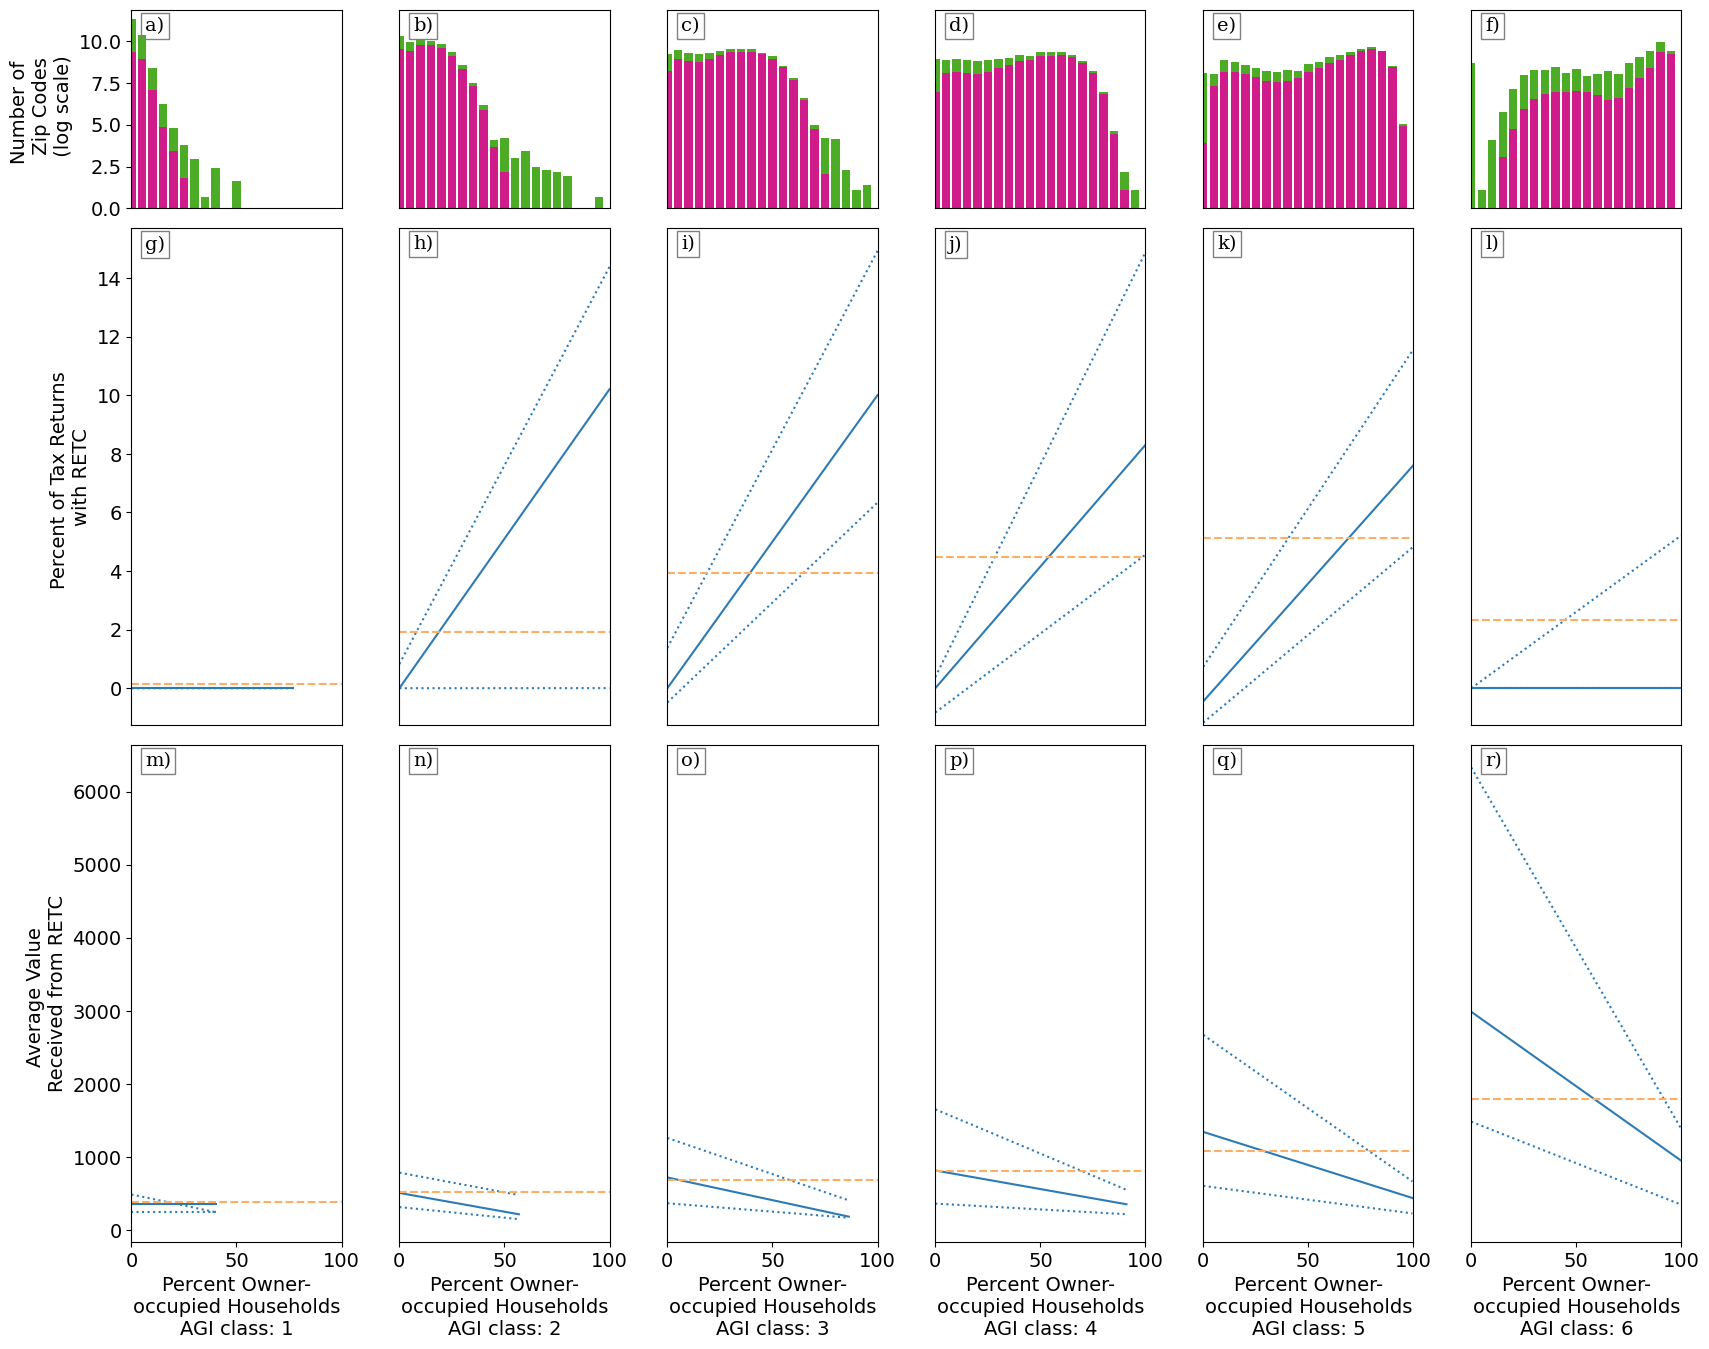

In [25]:
# Urban
tax_credit_dfs = []
unique_agi_stubs = list(range(1, 7))

for agi_stub in unique_agi_stubs:
    credits_at_agi_stub = credits_urban_df[
        (credits_urban_df["agi_stub"] == agi_stub)
    ]
    mean_value = credits_at_agi_stub[
        credits_at_agi_stub["Number of returns"] >= 1
    ]["value_returns"].mean()
    print(f"AGI stub {agi_stub}: mean value = {mean_value}")
    tax_credit_dfs.append(credits_at_agi_stub)


participation_polynomials = [1, 1, 1, 1, 1, 1]
value_polynomials = [1, 1, 1, 1, 1, 1]

quantile_regression_both_response_subplots_with_bootstrap_and_histograms_updated(
    tax_credit_dfs,
    "percent_homeowners",
    participation_polynomials,
    value_polynomials,
    segment="urban",
)

AGI stub 1: mean value = 458.6683480445016
AGI stub 2: mean value = 507.4186530122226
AGI stub 3: mean value = 605.1992810091201
AGI stub 4: mean value = 728.122010191628
AGI stub 5: mean value = 1056.3771487779527
AGI stub 6: mean value = 2327.6111479568744
Analysis of bucket 1
analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:           -2.327e-07
Model:                       QuantReg   Bandwidth:                   4.652e-10
Method:                 Least Squares   Sparsity:                          inf
Date:                Wed, 06 Mar 2024   No. Observations:               153829
Time:                        16:46:50   Df Residuals:                   153827
                                        Df Model:                            1
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:           -2.834e-06
Model:                       QuantReg   Bandwidth:                   2.102e-06
Method:                 Least Squares   Sparsity:                    6.365e-06
Date:                Wed, 06 Mar 2024   No. Observations:               146821
Time:                        16:46:52   Df Residuals:                   146819
                                        Df Model:                            1
                         coef    std err          t                 P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept          -3.583e-08  1.136e-08    -3.1539 0.0016114921019314765  -5.809e-08  -1.356e-08
percent_homeowners  9.149e-07  3.096e-10  2954.8712                   0.0   9.143e-07   9.155e-07
9.149255834658057e-07, 0.0, 9.1

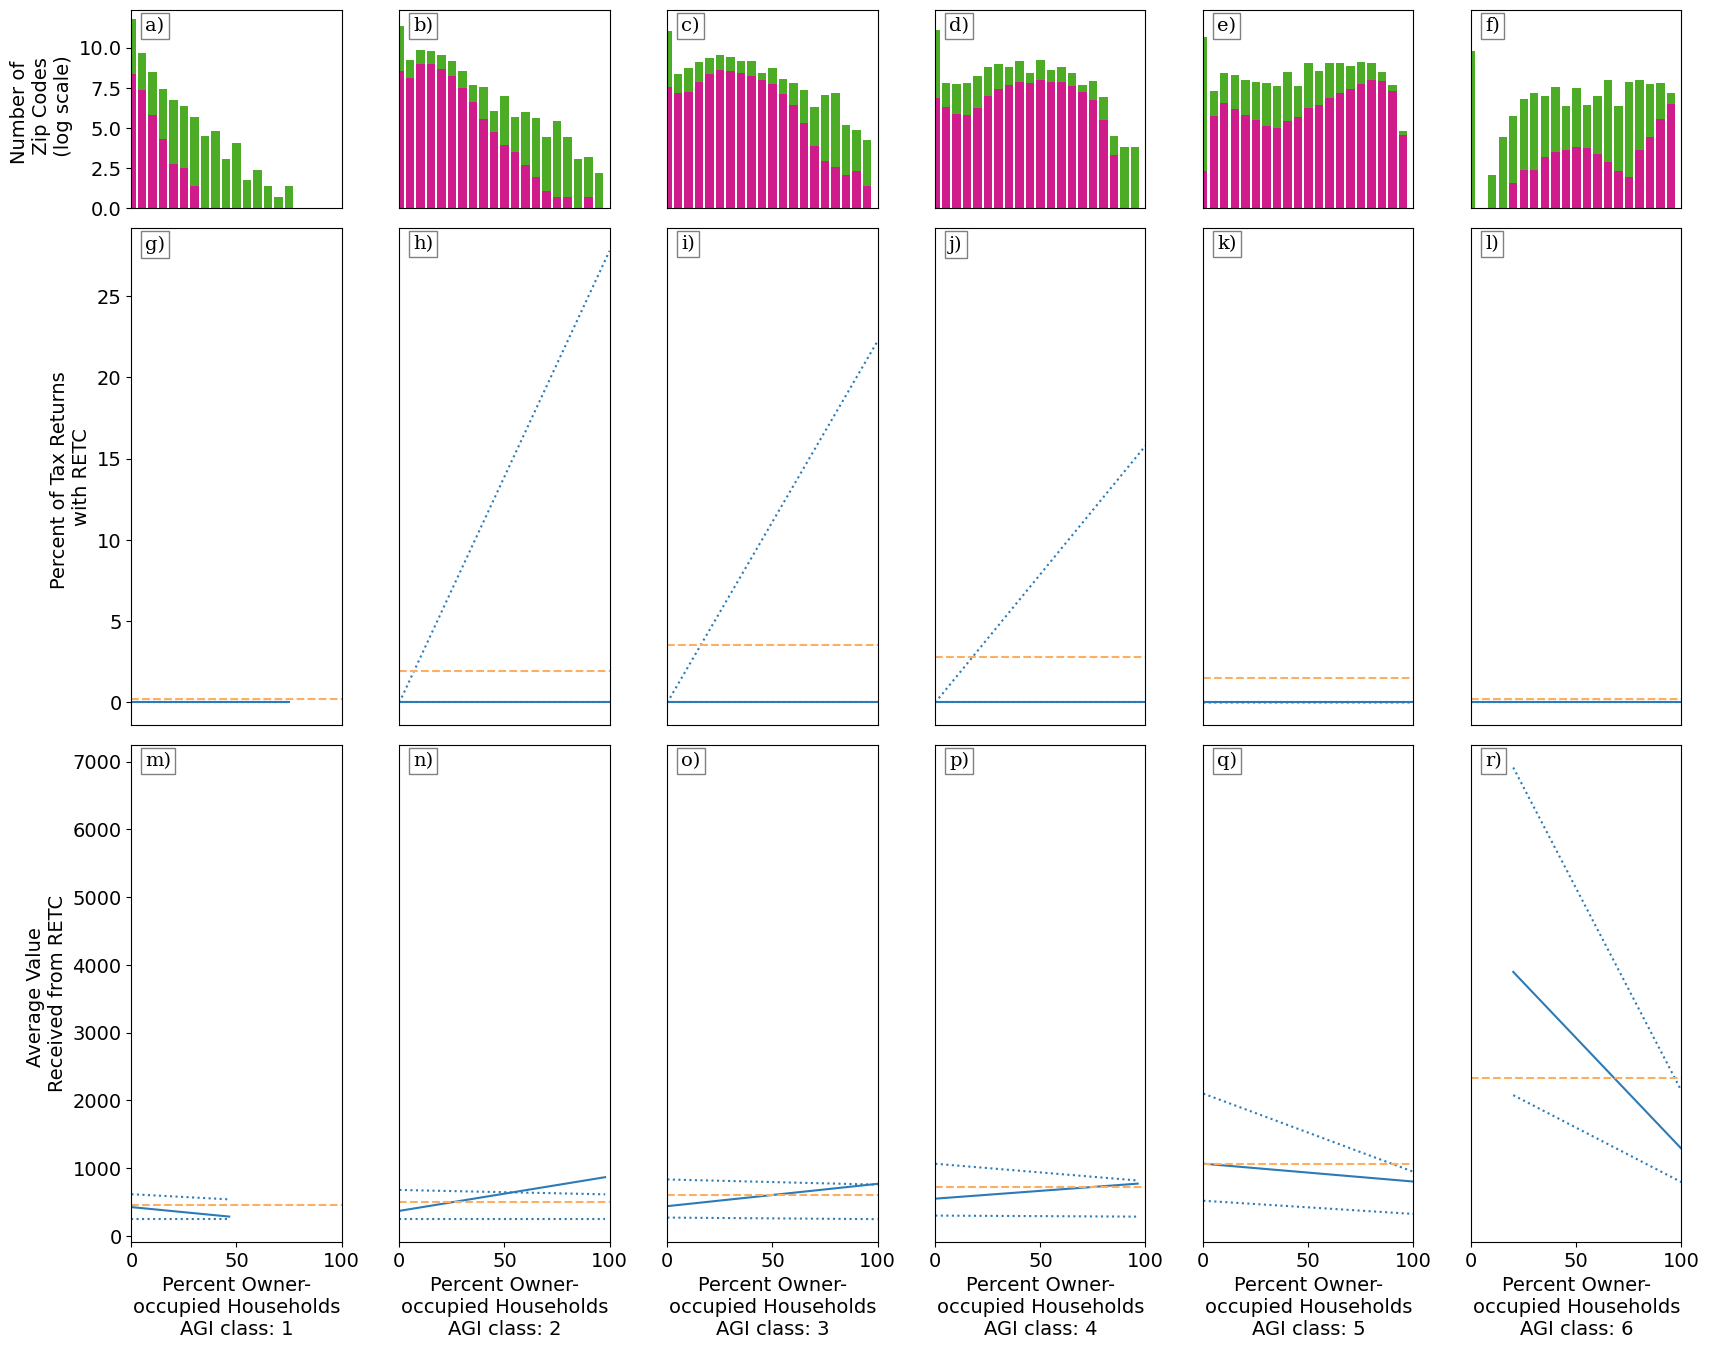

In [26]:
# Rural
tax_credit_dfs = []
unique_agi_stubs = list(range(1, 7))

for agi_stub in unique_agi_stubs:
    credits_at_agi_stub = credits_rural_df[
        (credits_rural_df["agi_stub"] == agi_stub)
    ]
    mean_value = credits_at_agi_stub[
        credits_at_agi_stub["Number of returns"] >= 1
    ]["value_returns"].mean()
    print(f"AGI stub {agi_stub}: mean value = {mean_value}")
    tax_credit_dfs.append(credits_at_agi_stub)


participation_polynomials = [1, 1, 1, 1, 1, 1]
value_polynomials = [1, 1, 1, 1, 1, 1]

quantile_regression_both_response_subplots_with_bootstrap_and_histograms_updated(
    tax_credit_dfs,
    "percent_homeowners",
    participation_polynomials,
    value_polynomials,
    segment="rural",
)

In [27]:
tmp = tax_credit_dfs[0]
len(tmp[tmp["Number of returns"] >= 1]) / len(tmp)

0.04051901787049256

In [28]:
# def run_quantile_regression(df, x_var, y_var, skip1=False):

df = tax_credit_dfs[0].dropna()
x_var = "percent_homeowners"
y_var = "percent_returns"
mod = smf.quantreg(f"{y_var} ~ {x_var}", df)

quantiles = [0.50]
res_all = []
for q in quantiles:
    res = mod.fit(q=q, missing="raise")

    print(res.summary())
    res_all.append(res)

                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:           -2.327e-07
Model:                       QuantReg   Bandwidth:                   4.652e-10
Method:                 Least Squares   Sparsity:                          inf
Date:                Wed, 06 Mar 2024   No. Observations:               153829
Time:                        16:46:56   Df Residuals:                   153827
                                        Df Model:                            1
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            2.96e-08        nan        nan        nan         nan         nan
percent_homeowners  1.025e-08        nan        nan        nan         nan         nan


## Race segmentation

In [29]:
agi_bands = [
    (0, 25000),
    (25000, 50000),
    (50000, 75000),
    (75000, 100000),
    (100000, 200000),
    (200000, 1000000),
]

In [30]:
# urban

# Data prep at zip code instead of AGI level
credits_zipcode_urban_df = credits_urban_df[
    [
        "zipcode",
        "Total Returns",
        "Number of returns",
        "Amount of returns",
        "percent_white_alone",
        "median_income",
    ]
]

credits_zipcode_urban_df.groupby(["zipcode"], as_index=False).agg(
    {
        "Total Returns": "sum",
        "Number of returns": "sum",
        "Amount of returns": "sum",
        "percent_white_alone": "first",
        "median_income": "first",
    }
)

credits_zipcode_urban_df = credits_zipcode_urban_df.dropna()

credits_zipcode_urban_df["percent_returns"] = 0
credits_zipcode_urban_df.loc[
    credits_zipcode_urban_df["Number of returns"] >= 1, "percent_returns"
] = (
    credits_zipcode_urban_df["Number of returns"].astype(float)
    / credits_zipcode_urban_df["Total Returns"].astype(float)
    * 100
)
credits_zipcode_urban_df["value_returns"] = 0
credits_zipcode_urban_df.loc[
    credits_zipcode_urban_df["Number of returns"] >= 1, "value_returns"
] = (
    credits_zipcode_urban_df["Amount of returns"].astype(float)
    / credits_zipcode_urban_df["Number of returns"].astype(float)
    * 1000
)


tax_credit_dfs = []
for ind, agi_band in enumerate(agi_bands):
    agi_band_min = agi_band[0]
    agi_band_max = agi_band[1]

    tax_credit_current_band = credits_zipcode_urban_df[
        (credits_zipcode_urban_df["median_income"] >= agi_band_min)
        & (credits_zipcode_urban_df["median_income"] < agi_band_max)
    ]
    tax_credit_dfs.append(tax_credit_current_band)
    mean_participation = tax_credit_current_band["percent_returns"].mean()
    median_participation = tax_credit_current_band["percent_returns"].median()
    print(
        f"AGI stub {ind+1}: {round(mean_participation,2)}\%  & {round(median_participation,2)}\%"
    )
    participating = tax_credit_current_band[
        tax_credit_current_band["Number of returns"] >= 1
    ]
    mean_value = participating["value_returns"].mean()
    median_value = participating["value_returns"].median()
    print(
        f"AGI stub {ind+1}: \${round(mean_value,2)} & \${round(median_value,2)}\n"
    )

AGI stub 1: 1.94\%  & 0.0\%
AGI stub 1: \$592.31 & \$515.21

AGI stub 2: 3.26\%  & 1.04\%
AGI stub 2: \$652.68 & \$466.67

AGI stub 3: 3.13\%  & 1.61\%
AGI stub 3: \$813.75 & \$533.33

AGI stub 4: 3.04\%  & 1.79\%
AGI stub 4: \$1006.64 & \$642.86

AGI stub 5: 2.57\%  & 1.04\%
AGI stub 5: \$1200.54 & \$758.62

AGI stub 6: 1.39\%  & 0.0\%
AGI stub 6: \$1774.22 & \$1071.43



Analysis of bucket 1
analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:           -9.008e-08
Model:                       QuantReg   Bandwidth:                      0.2072
Method:                 Least Squares   Sparsity:                       0.3895
Date:                Wed, 06 Mar 2024   No. Observations:                12666
Time:                        16:46:57   Df Residuals:                    12664
                                        Df Model:                            1
                          coef    std err          t              P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept            7.245e-07     0.0026     0.0003 0.9997787077295618     -0.0051      0.0051
percent_white_alone  -8.31e-09  7.009e-05    -0.0001 0.9999053938979641     -0.0001      0.0001
-8.310355474449571

Analysis of bucket 4
analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:             0.003210
Model:                       QuantReg   Bandwidth:                      0.3129
Method:                 Least Squares   Sparsity:                        9.602
Date:                Wed, 06 Mar 2024   No. Observations:               135670
Time:                        16:47:03   Df Residuals:                   135668
                                        Df Model:                            1
                          coef    std err          t                  P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept               0.8725     0.0464    18.7907 1.1335758206786506e-78      0.7815      0.9635
percent_white_alone     0.0143     0.0006    22.6030 6.549432272377417e-113      0.0131      0.0156
0.

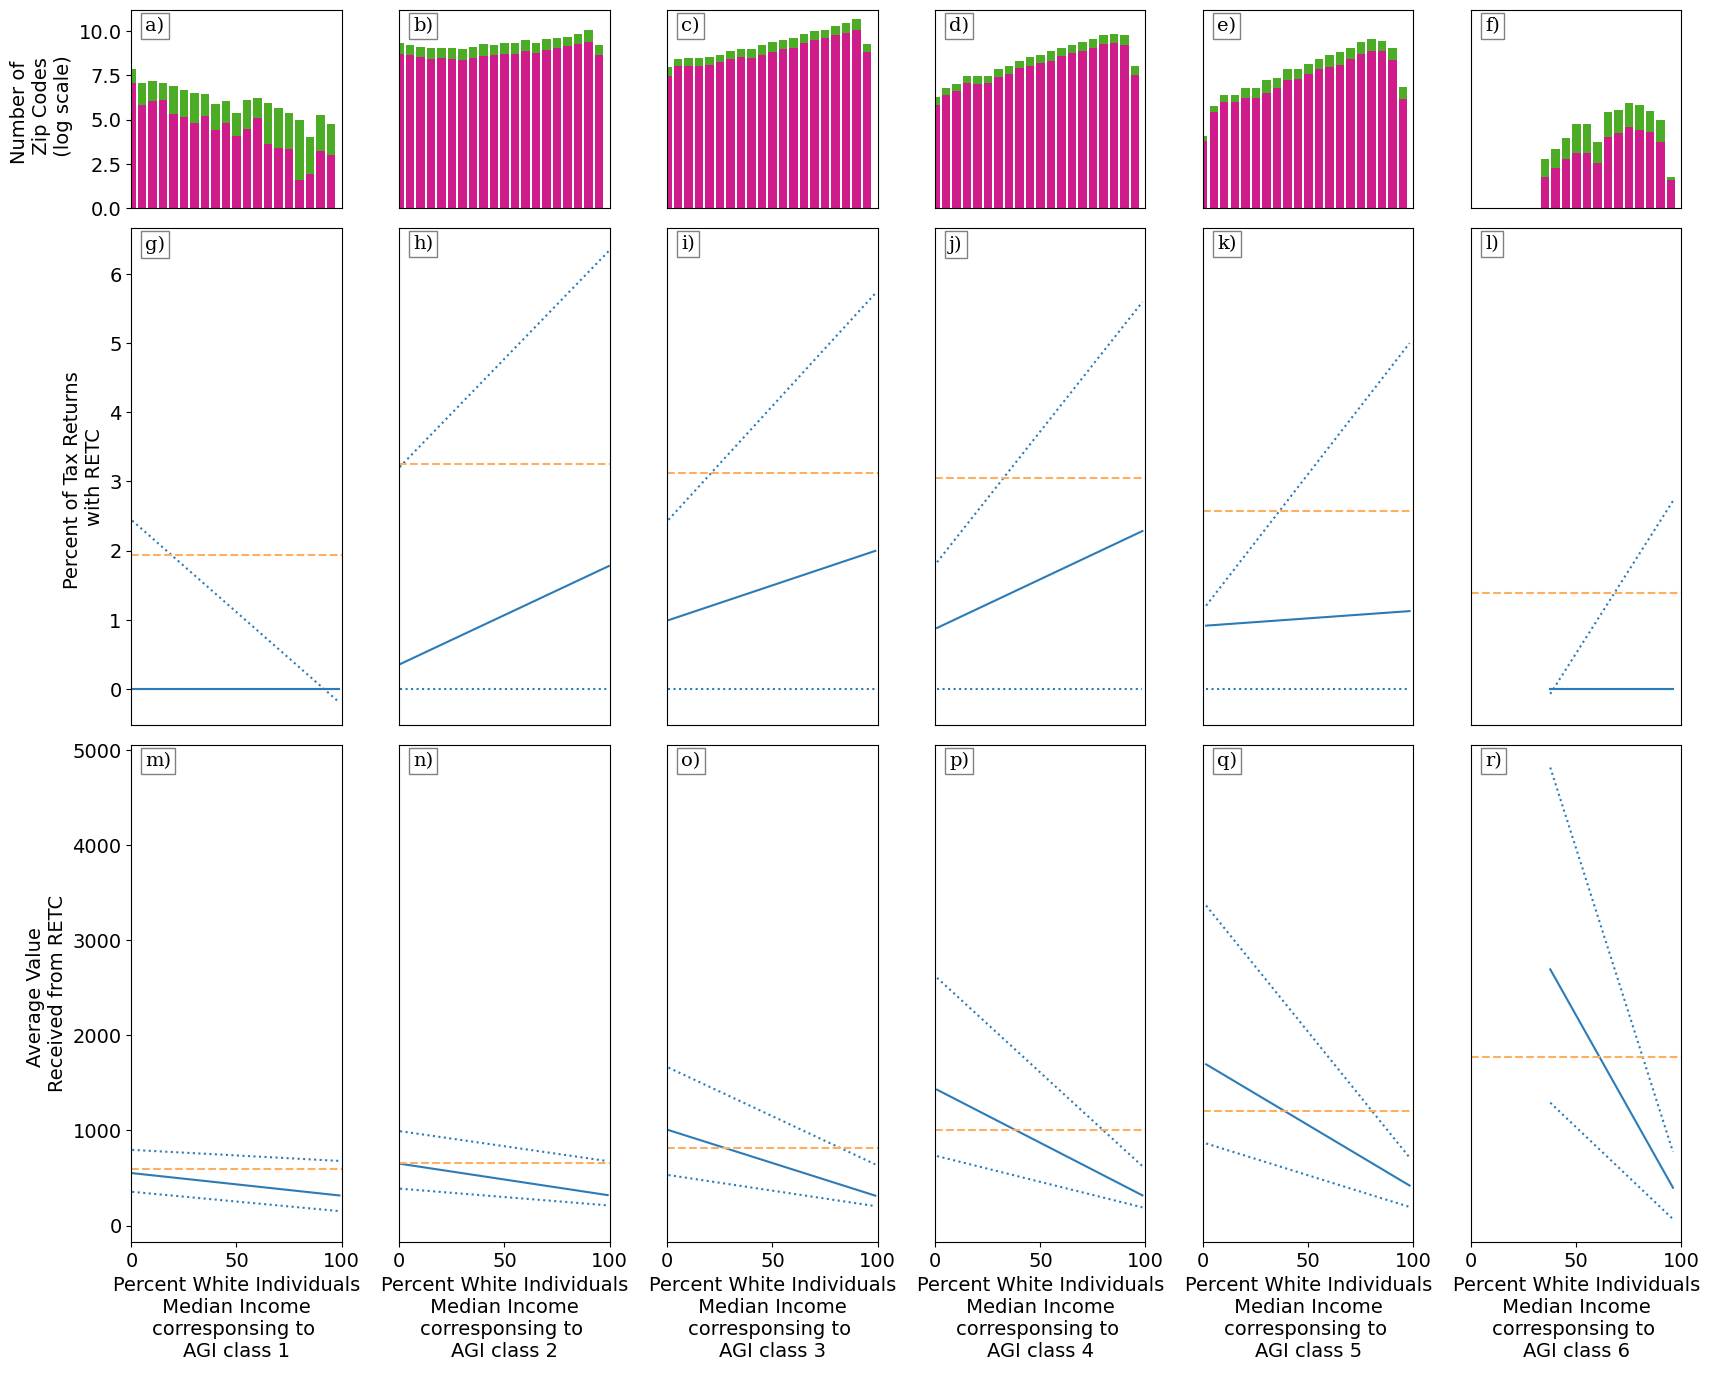

In [31]:
participation_polynomials = [1, 1, 1, 1, 1, 1]
value_polynomials = [1, 1, 1, 1, 1, 1]

quantile_regression_both_response_subplots_with_bootstrap_and_histograms_updated(
    tax_credit_dfs,
    "percent_white_alone",
    participation_polynomials,
    value_polynomials,
    segment="urban",
)

In [32]:
# Rural

# Data prep at zip code instead of AGI level
credits_zipcode_rural_df = credits_rural_df[
    [
        "zipcode",
        "Total Returns",
        "Number of returns",
        "Amount of returns",
        "percent_white_alone",
        "median_income",
    ]
]

credits_zipcode_rural_df.groupby(["zipcode"], as_index=False).agg(
    {
        "Total Returns": "sum",
        "Number of returns": "sum",
        "Amount of returns": "sum",
        "percent_white_alone": "first",
        "median_income": "first",
    }
)

credits_zipcode_rural_df = credits_zipcode_rural_df.dropna()
credits_zipcode_rural_df["percent_returns"] = 0
credits_zipcode_rural_df.loc[
    credits_zipcode_rural_df["Number of returns"] >= 1, "percent_returns"
] = (
    credits_zipcode_rural_df["Number of returns"].astype(float)
    / credits_zipcode_rural_df["Total Returns"].astype(float)
    * 100
)
credits_zipcode_rural_df["value_returns"] = 0
credits_zipcode_rural_df.loc[
    credits_zipcode_rural_df["Number of returns"] >= 1, "value_returns"
] = (
    credits_zipcode_rural_df["Amount of returns"].astype(float)
    / credits_zipcode_rural_df["Number of returns"].astype(float)
    * 1000
)

tax_credit_dfs = []
for ind, agi_band in enumerate(agi_bands):
    agi_band_min = agi_band[0]
    agi_band_max = agi_band[1]

    tax_credit_current_band = credits_zipcode_rural_df[
        (credits_zipcode_rural_df["median_income"] >= agi_band_min)
        & (credits_zipcode_rural_df["median_income"] < agi_band_max)
    ]
    tax_credit_dfs.append(tax_credit_current_band)

    mean_participation = tax_credit_current_band["percent_returns"].mean()
    median_participation = tax_credit_current_band["percent_returns"].median()
    print(
        f"AGI stub {ind+1}: {round(mean_participation,2)}\%  & {round(median_participation,2)}\%"
    )
    participating = tax_credit_current_band[
        tax_credit_current_band["Number of returns"] >= 1
    ]
    mean_value = participating["value_returns"].mean()
    median_value = participating["value_returns"].median()
    print(
        f"AGI stub {ind+1}: \${round(mean_value,2)} & \${round(median_value,2)}\n"
    )

AGI stub 1: 0.66\%  & 0.0\%
AGI stub 1: \$694.77 & \$666.67

AGI stub 2: 1.9\%  & 0.0\%
AGI stub 2: \$603.09 & \$550.0

AGI stub 3: 1.94\%  & 0.0\%
AGI stub 3: \$661.18 & \$541.67

AGI stub 4: 1.85\%  & 0.0\%
AGI stub 4: \$883.69 & \$619.05

AGI stub 5: 1.94\%  & 0.0\%
AGI stub 5: \$1205.57 & \$814.29

AGI stub 6: 1.27\%  & 0.0\%
AGI stub 6: \$1294.93 & \$1133.33



Analysis of bucket 1
analyzing participation
                         QuantReg Regression Results                          
Dep. Variable:        percent_returns   Pseudo R-squared:           -6.837e-08
Model:                       QuantReg   Bandwidth:                   4.824e-09
Method:                 Least Squares   Sparsity:                          inf
Date:                Wed, 06 Mar 2024   No. Observations:                12178
Time:                        16:47:08   Df Residuals:                    12176
                                        Df Model:                            1
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             8.07e-08        nan        nan        nan         nan         nan
percent_white_alone -4.737e-10        nan        nan        nan         nan         nan
-4.737140977503459e-10, nan, nan, nan 



mean = 0

mean = 1.8452925284038253
median = 0.0
analyzing value
mean = 883.6900889562389
median = 619.047619047619
                         QuantReg Regression Results                          
Dep. Variable:          value_returns   Pseudo R-squared:              0.01688
Model:                       QuantReg   Bandwidth:                       111.6
Method:                 Least Squares   Sparsity:                        1788.
Date:                Wed, 06 Mar 2024   No. Observations:                12210
Time:                        16:47:10   Df Residuals:                    12208
                                        Df Model:                            1
                          coef    std err          t                  P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept            2015.5733    77.0409    26.1624 7.618354099762971e-147   1864.5609   2166.5857
percent_white_alone   -15.5322     0.8613

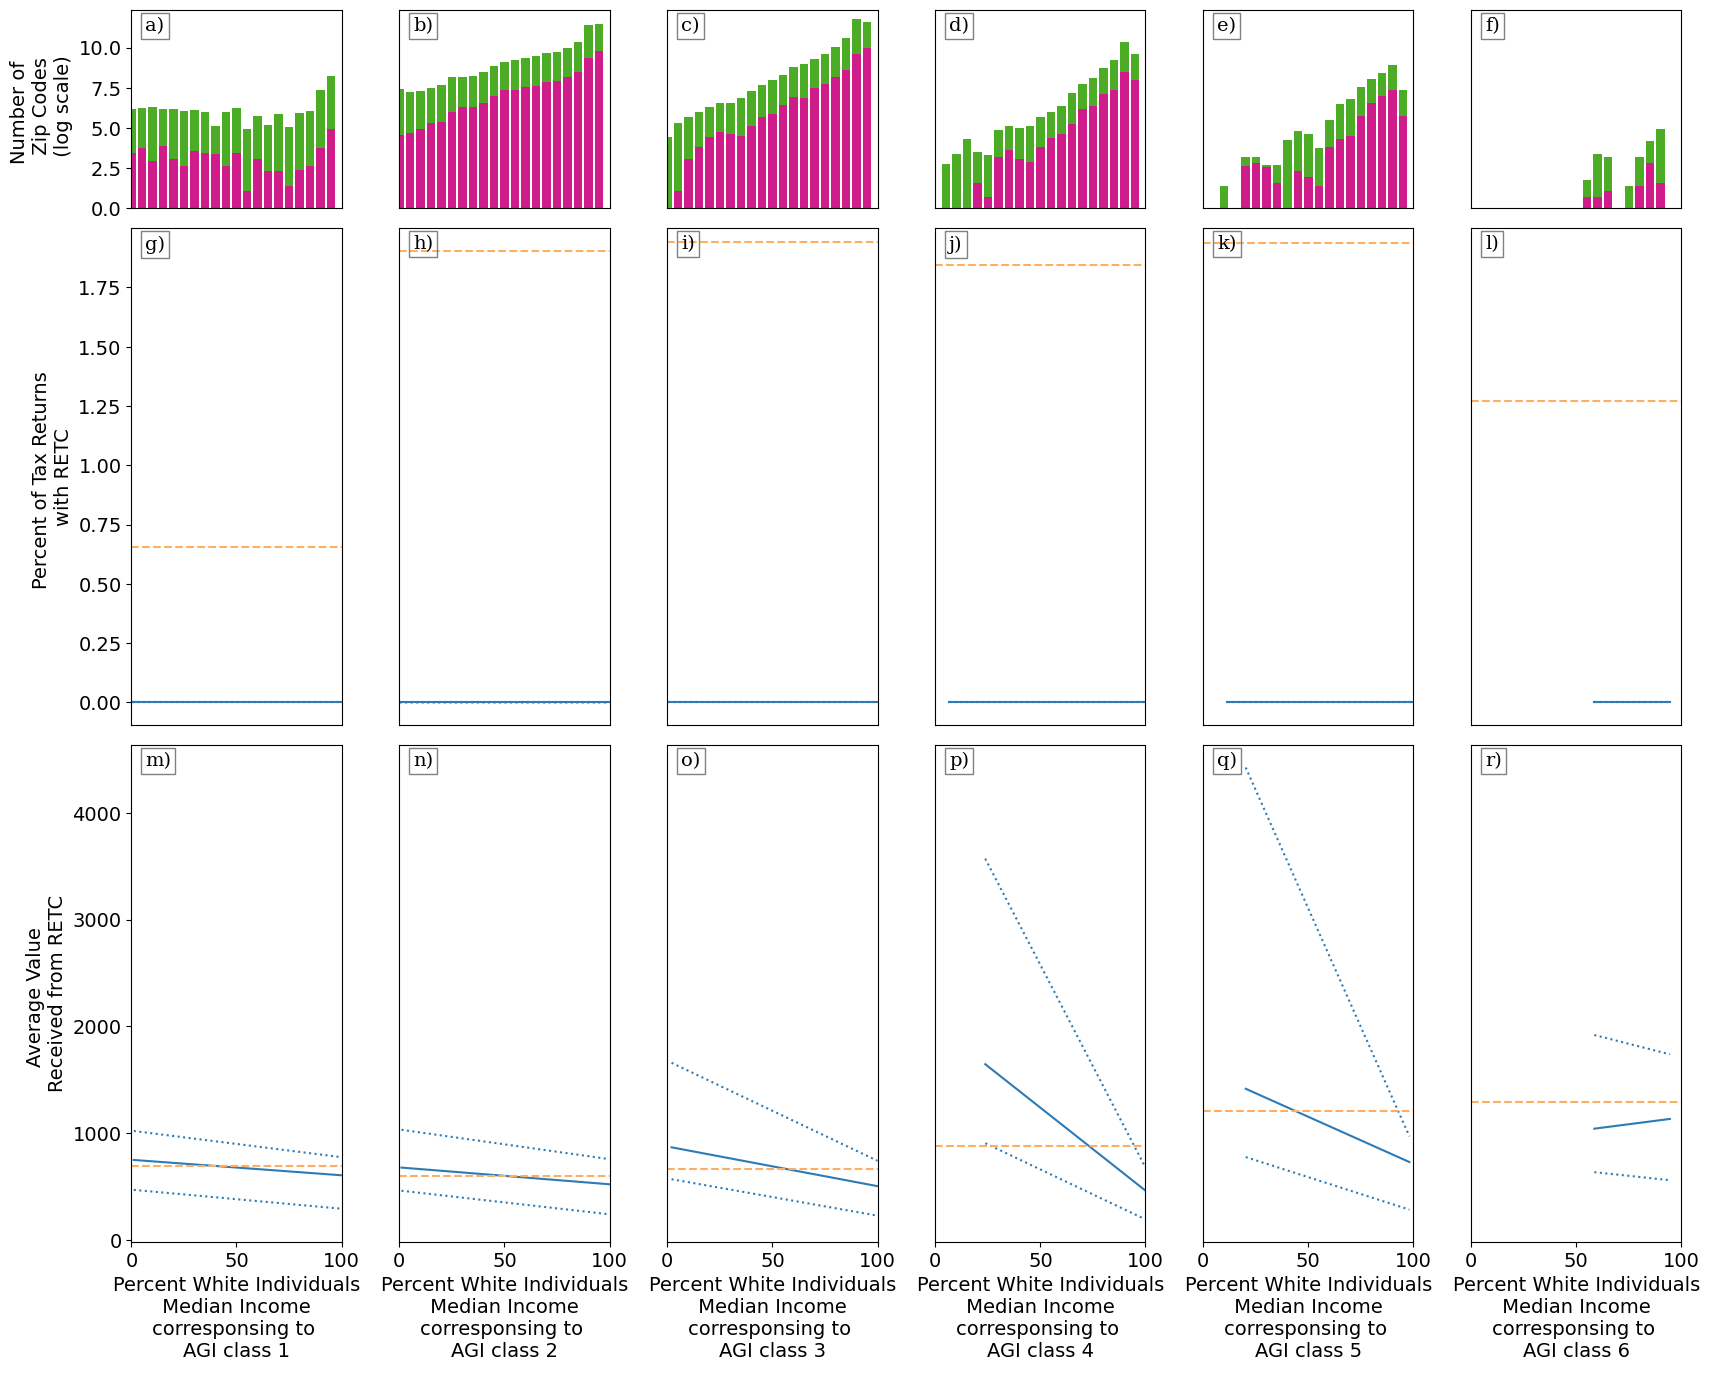

In [33]:
participation_polynomials = [1, 1, 1, 1, 1, 1]
value_polynomials = [1, 1, 1, 1, 1, 1]

quantile_regression_both_response_subplots_with_bootstrap_and_histograms_updated(
    tax_credit_dfs,
    "percent_white_alone",
    participation_polynomials,
    value_polynomials,
    segment="rural",
)

In [34]:
agi6df = tax_credit_dfs[-1]

In [35]:
agi6df["percent_white_alone"].min()

58.56332215630642